In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp
from deepmeg.utils.viz import plot_metrics

In [129]:

def accuracy(predictions, targets):
    """
    Computes the accuracy metric for multiclass tasks with one-hot encoded labels.

    Args:
    - predictions: A PyTorch tensor of shape (batch_size, num_classes) representing the model's predictions.
    - targets: A PyTorch tensor of shape (batch_size, num_classes) representing the true labels in one-hot encoded format.

    Returns:
    - accuracy: A float value representing the accuracy metric.
    """

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return torch.Tensor(accuracy)

In [2]:
dataset = read_epochs_dataset('../data/multimodal.pt')

In [3]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [45]:
from copy import deepcopy
from deepmeg.training.callbacks import Callback

import torch

class RepeatedBatchFitting(Callback):
    def __init__(self, n_iters=5):
        super().__init__()
        self.n_iters = n_iters
        self.reset_params()

    def reset_params(self):
        self.initital_batch_weights = None
        self.final_batch_weights = None
        self.data = list()
        self.original_loss = None

    def set_trainer(self, trainer: 'Trainer'):
        """
        Binds the trainer to the callback.

        Args:
            trainer (Trainer): The trainer object to bind to the callback.
        """
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.criterion = self.trainer.criterion

    def on_train_batch_begin(self, X, Y):
        self.data.append((X, Y))
        self.initital_batch_weights = deepcopy(self.model.state_dict())

    def on_train_batch_end(self, targets, predictions, metrics):
        self.original_loss = metrics['loss']
        self.final_batch_weights = deepcopy(self.model.state_dict())
        for i in range(self.n_iters):
            self.repeat_batch()
        self.reset_model(self.final_batch_weights)

    def reset_model(self, state_dict):
        self.model.load_state_dict(state_dict)

    def repeat_batch(self):
        self.reset_model(self.initital_batch_weights)
        self.trainer.optimizer.zero_grad()

        predictions = []
        targets = []
        losses = []

        for xs, ys_true in self.data:
            self.trainer.attach_tensors_to_device(xs, ys_true)

            # if self.trainer.callbacks:
            #     for callback in self.trainer.callbacks:
            #         if callback.__class__.__name__ != 'RepeatedBatchFitting':
            #             callback.on_batch_begin(xs, ys_true)
            #             callback.on_train_batch_begin(xs, ys_true)

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            if self.trainer.callbacks:
                for callback in self.trainer.callbacks:
                    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)

                    if new_loss is not None:
                        loss = new_loss

            (loss / len(self.data)).backward()
            losses.append(loss.item())

            predictions.append(ys_pred.to(self.trainer.device))
            targets.append(ys_true.to(self.trainer.device))

        self.trainer.optimizer.step()
        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)
        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.trainer.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        print(metrics['loss'], self.criterion(predictions, targets).item())

        # if self.callbacks:
        #     for callback in self.callbacks:
        #         if callback.__class__.__name__ != 'RepeatedBatchFitting':
        #             callback.on_batch_end(targets, predictions, metrics)
        #             callback.on_train_batch_end(targets, predictions, metrics)

In [166]:
from copy import deepcopy
from deepmeg.training.callbacks import Callback

import torch

class RepeatedEpochFitting(Callback):
    def __init__(self, n_iters=5, monitor='loss_train', minimize=True):
        super().__init__()
        self.n_iters = n_iters
        self.monitor = monitor
        self.minimize = minimize
        self.reset_params()

    def reset_params(self, best_epoch_weights=None, best_value=None):
        self.initial_epoch_weights = None
        self.best_epoch_weights = best_epoch_weights
        self.best_value = best_value
        self.counter = 0

    def reset_model(self, state_dict):
        self.model.load_state_dict(state_dict)

    def set_trainer(self, trainer: 'Trainer'):
        """
        Binds the trainer to the callback.

        Args:
            trainer (Trainer): The trainer object to bind to the callback.
        """
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.criterion = self.trainer.criterion

    def on_epoch_begin(self, n_epoch):
        self.initial_epoch_weights = deepcopy(self.model.state_dict())

        if self.best_epoch_weights is None:
            self.best_epoch_weights = deepcopy(self.initial_epoch_weights)

    def on_epoch_end(self, n_epoch, metrics):
        if self.counter < self.n_iters:
            # if self.best_value is not None:
            #     best_value = self.best_value.item() if isinstance(self.best_value, torch.Tensor) else self.best_value
            #     metric_valus = metrics[self.monitor].item() if isinstance(metrics[self.monitor], torch.Tensor) else metrics[self.monitor]
            #     print(f'Repeating epoch {self.n_iters - self.counter}, best {self.monitor}: {best_value : .3f}, current {self.monitor}: {metric_valus : .3f}')
            # else:
            #     print(f'Repeating epoch {self.n_iters - self.counter}')

            if self.best_value is None:
                self.best_value = metrics[self.monitor]
            else:
                if self.minimize:
                    if self.best_value > metrics[self.monitor]:
                        self.best_value = metrics[self.monitor]
                        self.best_epoch_weights = deepcopy(self.model.state_dict())
                else:
                    if self.best_value < metrics[self.monitor]:
                        self.best_value = metrics[self.monitor]
                        self.best_epoch_weights = deepcopy(self.model.state_dict())

            self.reset_model(self.initial_epoch_weights)
            self.counter += 1
        else:
            self.reset_model(self.best_epoch_weights)
            self.reset_params(self.best_epoch_weights, self.best_value)

In [86]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [87]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7268   |    accuracy_train:  0.1117   |    loss_val:  0.7078   |    accuracy_val:  0.1263
Epoch 1:  loss_train:  0.6996   |    accuracy_train:  0.1461   |    loss_val:  0.6843   |    accuracy_val:  0.1486
Epoch 2:  loss_train:  0.6723   |    accuracy_train:  0.1792   |    loss_val:  0.6589   |    accuracy_val:  0.1430
Epoch 3:  loss_train:  0.6428   |    accuracy_train:  0.2289   |    loss_val:  0.6309   |    accuracy_val:  0.1708
Epoch 4:  loss_train:  0.6105   |    accuracy_train:  0.2736   |    loss_val:  0.5995   |    accuracy_val:  0.1986
Epoch 5:  loss_train:  0.5749   |    accuracy_train:  0.3015   |    loss_val:  0.5645   |    accuracy_val:  0.2208
Epoch 6:  loss_train:  0.5365   |    accuracy_train:  0.3184   |    loss_val:  0.5273   |    accuracy_val:  0.2152
Epoch 7:  loss_train:  0.4979   |    accuracy_train:  0.3365   |    loss_val:  0.4921   |    accuracy_val:  0.2263
Epoch 8:  loss_train:  0.4640   |    accuracy_train:  0.3594   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

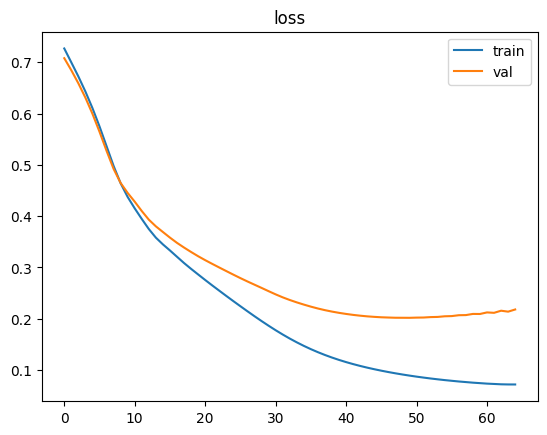

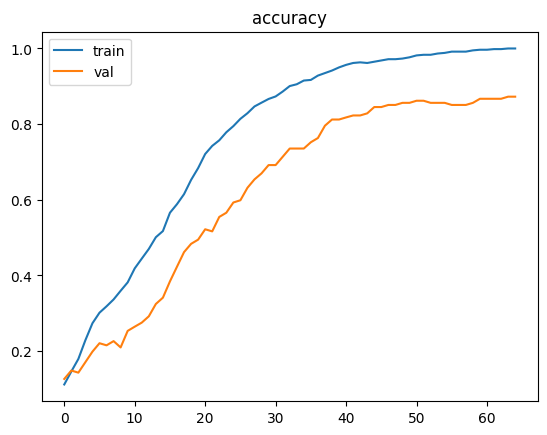

In [88]:
history = model.fit(train, n_epochs=1500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [89]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.11928189613602379
train_accuracy: 0.9410839189182628
loss: 0.22084346955472772
accuracy: 0.7662337747487155


In [155]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        RepeatedBatchFitting(5),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [156]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7130   |    accuracy_train:  0.1317   |    loss_val:  0.6980   |    accuracy_val:  0.1260
Epoch 1:  loss_train:  0.7124   |    accuracy_train:  0.1332   |    loss_val:  0.6984   |    accuracy_val:  0.1260
Epoch 2:  loss_train:  0.7123   |    accuracy_train:  0.1363   |    loss_val:  0.6984   |    accuracy_val:  0.1260
Epoch 3:  loss_train:  0.7122   |    accuracy_train:  0.1363   |    loss_val:  0.6984   |    accuracy_val:  0.1260
Epoch 4:  loss_train:  0.7122   |    accuracy_train:  0.1363   |    loss_val:  0.6984   |    accuracy_val:  0.1260
Epoch 5:  loss_train:  0.7122   |    accuracy_train:  0.1363   |    loss_val:  0.6984   |    accuracy_val:  0.1260
Epoch 6:  loss_train:  0.6860   |    accuracy_train:  0.1530   |    loss_val:  0.6749   |    accuracy_val:  0.1371
Epoch 7:  loss_train:  0.6858   |    accuracy_train:  0.1530   |    loss_val:  0.6739   |    accuracy_val:  0.1371
Epoch 8:  loss_train:  0.6857   |    accuracy_train:  0.1530   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

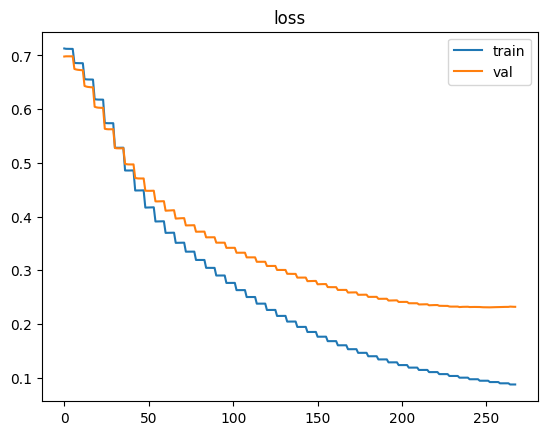

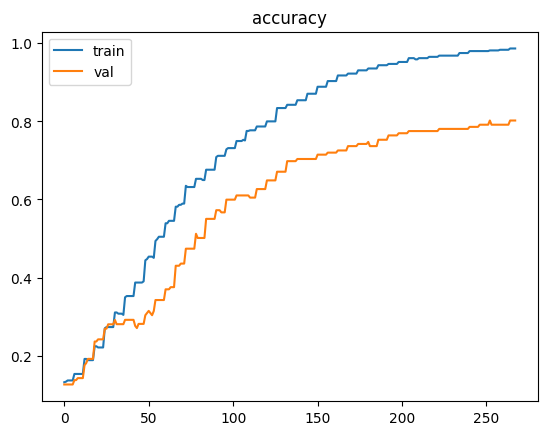

In [157]:
history = model.fit(train, n_epochs=1500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [158]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12419366430152547
train_accuracy: 0.9398601434447549
loss: 0.26649185473268683
accuracy: 0.792207804593173


In [167]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        RepeatedEpochFitting(10),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [168]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7147   |    accuracy_train:  0.1525   |    loss_val:  0.6934   |    accuracy_val:  0.1267
Epoch 1:  loss_train:  0.7143   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 2:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 3:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 4:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 5:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 6:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 7:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0.6937   |    accuracy_val:  0.1156
Epoch 8:  loss_train:  0.7142   |    accuracy_train:  0.1604   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

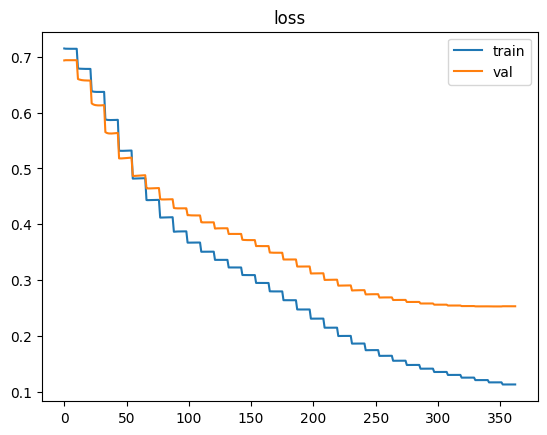

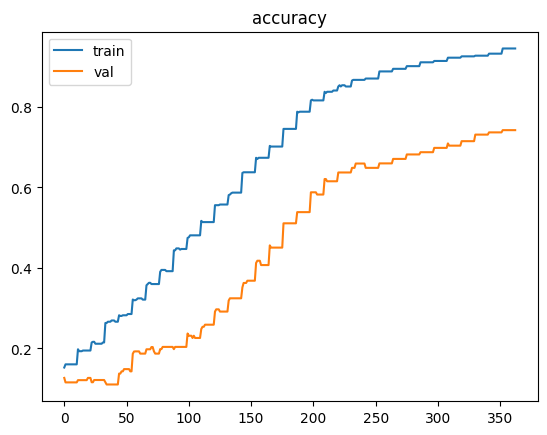

In [169]:
history = model.fit(train, n_epochs=1500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [174]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14952462708408182
train_accuracy: 0.8937063000418923
loss: 0.20570447499101813
accuracy: 0.78896103663878


In [151]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        RepeatedBatchFitting(25),
        EarlyStopping(patience=26, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [152]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7100   |    accuracy_train:  0.1253   |    loss_val:  0.6947   |    accuracy_val:  0.1545
Epoch 1:  loss_train:  0.7095   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 2:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 3:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 4:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 5:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 6:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 7:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0.6950   |    accuracy_val:  0.1600
Epoch 8:  loss_train:  0.7094   |    accuracy_train:  0.1317   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

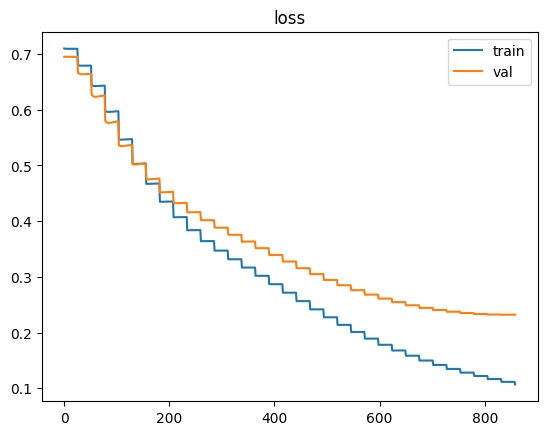

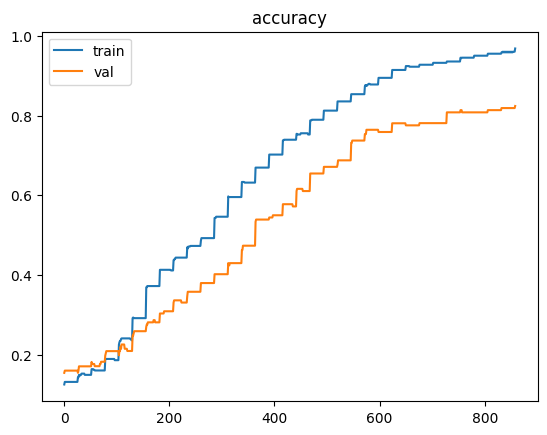

In [153]:
history = model.fit(train, n_epochs=1500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [154]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14287825741551138
train_accuracy: 0.9087412628260526
loss: 0.21038047156550668
accuracy: 0.8149350664832375


In [143]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        # PrintingCallback(), # print ongoing training history
        RepeatedBatchFitting(10, monitor='accuracy_train', minimize=False),
        # EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [144]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [145]:
history = model.fit(train, n_epochs=1500, batch_size=200, val_batch_size=60)
plot_metrics(history)

Repeating epoch 10                      
Repeating epoch 9, best accuracy_train:  0.127, current accuracy_train:  0.129
Repeating epoch 8, best accuracy_train:  0.129, current accuracy_train:  0.129
Repeating epoch 7, best accuracy_train:  0.129, current accuracy_train:  0.129
Repeating epoch 6, best accuracy_train:  0.129, current accuracy_train:  0.132
Repeating epoch 5, best accuracy_train:  0.132, current accuracy_train:  0.132
Repeating epoch 4, best accuracy_train:  0.132, current accuracy_train:  0.132
Repeating epoch 3, best accuracy_train:  0.132, current accuracy_train:  0.132
Repeating epoch 2, best accuracy_train:  0.132, current accuracy_train:  0.132
Repeating epoch 1, best accuracy_train:  0.132, current accuracy_train:  0.132
Repeating epoch 10, best accuracy_train:  0.132, current accuracy_train:  0.151
Repeating epoch 9, best accuracy_train:  0.151, current accuracy_train:  0.156
Repeating epoch 8, best accuracy_train:  0.156, current accuracy_train:  0.158
Repeating 

KeyboardInterrupt: 

In [146]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12031983584165573
train_accuracy: 0.9326923110268333
loss: 0.192933896725828
accuracy: 0.8344155820933256
